# Time Series Project

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
!pip install -U scikit-learn

import pandas as pd
import numpy as np
import math
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
import xgboost as xgb
from xgboost import XGBRegressor
!pip install pmdarima
from pmdarima import auto_arima  
from statsmodels.tools.eval_measures import mse,rmse
# for determining ARIMA orders

In [2]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


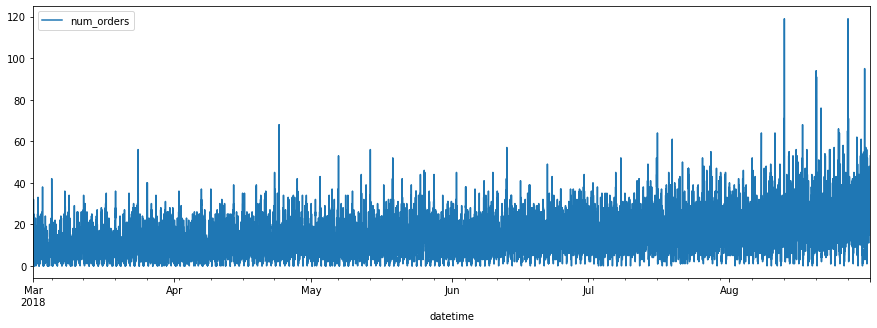

In [5]:
df.sort_index(inplace=True)
# data = data['2018-01':'2018-06']
df.plot(figsize=(15,5));

Let's zoom in on the end:

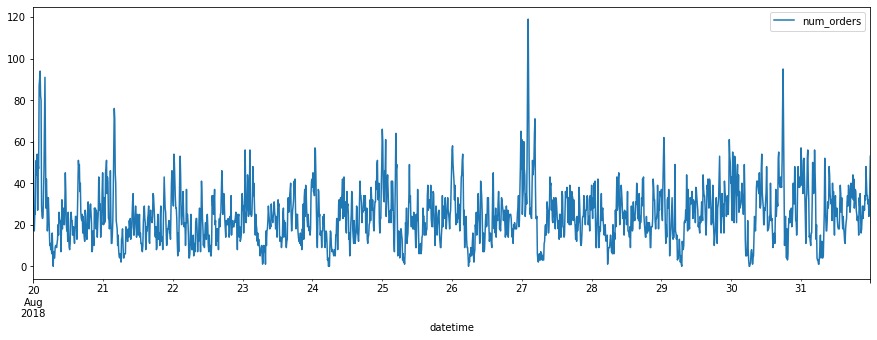

In [6]:
df['2018-08-20':].plot(figsize=(15,5));

It's hard to notice a trend or seasonality in the data since there is no obvious pattern. Let's examine a little more and also aggregate the data.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


In [8]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


The hourly usage of taxis changes between 0 to 119 rides with mean and median close to each other around 13-14.

In [9]:
df.index.min()

Timestamp('2018-03-01 00:00:00')

In [10]:
df.index.max()

Timestamp('2018-08-31 23:50:00')

The data is from the year 2018 and spans from March 1st till the end of August.

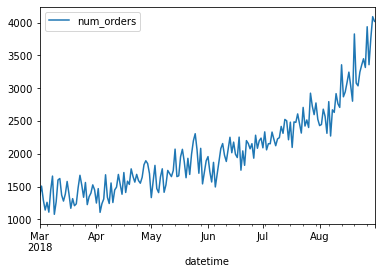

In [11]:
df_day = df.resample('1D').sum() 
df_day.plot();

The daily taxi rides have a clear upwards trend and seasonality. Let's decompose it to see better.

A trend is a smooth change of the mean value of the series without repeating patterns. For example, annual increase in sales of airline tickets.

Seasonality means cyclically repeating patterns in a time series. For instance, the growth of airline tickets sales each summer.

Trends and seasonality depend on the scale of the data.

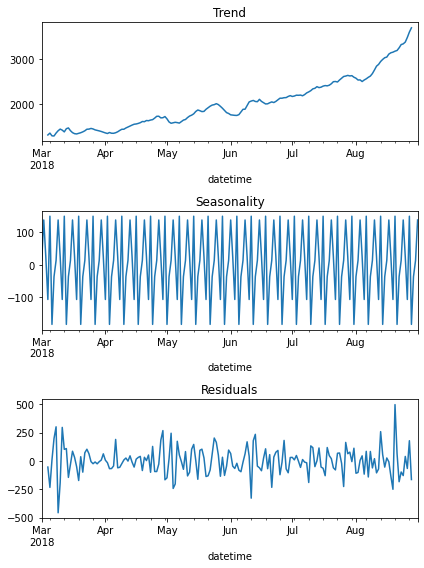

In [12]:
fro='2018-03-01'
to='2018-08-31'
decomposed = seasonal_decompose(df_day)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend[fro:to].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal[fro:to].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid[fro:to].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Trend is more than linear, notice a small upward take off after the beginning of August. Also notice that trend is projecting upward .
Seasonal pattern is consistent
Residuals are whatever is left after fitting the trend and seasonal components to the observed data. It's the component we cannot explain. We want the residuals to be i.i.d (i.e uncorrelated). If the residuals have a pattern, it means there is still some structural information left to be captured. 

Let's examine the data in an hourly aggregation so we can forecast the next hour.

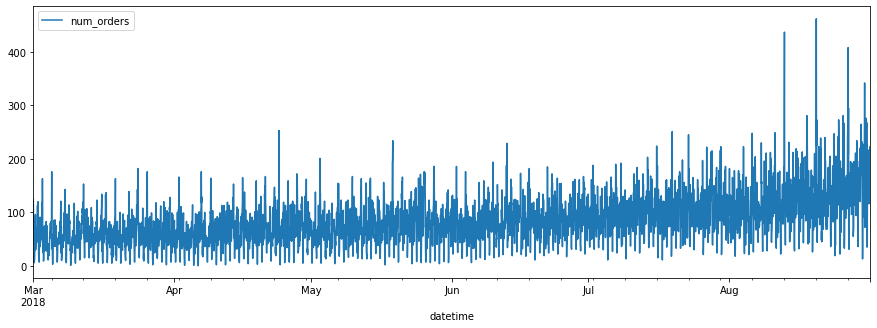

In [13]:
df = df.resample('1H').sum() 
df.plot(figsize=(15,5));

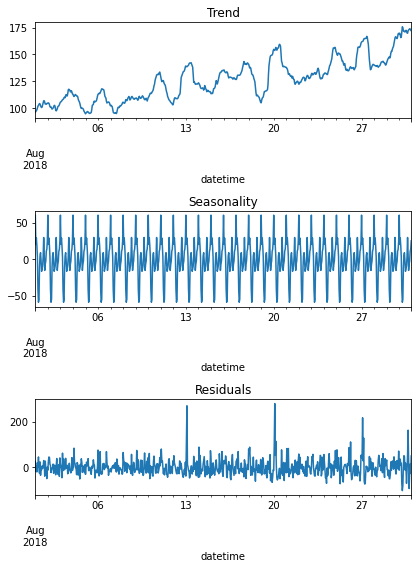

In [14]:
fro='2018-08-01'
to='2018-08-30'
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend[fro:to].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal[fro:to].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid[fro:to].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

The trend looks weird. I'm not sure if it realy has a trend depended on the time. Let's find out using Dickey-Fuller test.

Stationary series can help forecast data. Let's find out about our data.

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [16]:
adf_test(df['num_orders'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -3.068924
p-value                    0.028940
# lags used               30.000000
# observations          4385.000000
critical value (1%)       -3.431842
critical value (5%)       -2.862199
critical value (10%)      -2.567121
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


We see that the data is stationary so we won't need to calculate the lag differences.

### Creating Features

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
df_original = df.copy()

make_features(df,3,3)                   

In [18]:
df

,num_orders,year,month,day,hour,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,0,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,2,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,93.333333
2018-03-01 04:00:00,43,2018,3,1,4,3,66.0,71.0,85.0,74.000000
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,19,4,207.0,217.0,197.0,207.000000
2018-08-31 20:00:00,154,2018,8,31,20,4,136.0,207.0,217.0,186.666667
2018-08-31 21:00:00,159,2018,8,31,21,4,154.0,136.0,207.0,165.666667


The train_test_split() function from the sklearn.model_selection module mixes data by default, so let's set the shuffle argument to False so the data can be separated correctly into training and test sets and prevent data leakage:

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.12)

print('Train range: From',train.index.min(),'To', train.index.max())
print('Test range: From',test.index.min(), 'To', test.index.max())

Train range: From 2018-03-01 00:00:00 To 2018-08-09 21:00:00
Test range: From 2018-08-09 22:00:00 To 2018-08-31 23:00:00


## Models training and predictions:

### Linear regression model

In [20]:
# train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()
train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']
reg = LinearRegression().fit(train_features, train_target)
prediction_train = reg.predict(train_features)
prediction_test = reg.predict(test_features)


print("RMSE for the training set:", math.sqrt(mean_squared_error(train_target, prediction_train)))
print("RMSE for the test set: ", math.sqrt(mean_squared_error(test_target, prediction_test)))

RMSE for the training set: 29.97862376689097
RMSE for the test set:  52.34595070078655


Linear regression model using the features we've created earlier: year, month, day, hour and dayofweek got an RMSE score of 52 on the test set. Not so good.

### XGBoost

In [21]:

# import numpy as np
X_train = train.drop('num_orders',axis=1)
y_train = train.num_orders
   
model = XGBRegressor()           
param_search = {'max_depth' : [3, 5]}

tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=param_search,scoring= 'neg_root_mean_squared_error')
gsearch.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
             

In [22]:
print(gsearch.best_estimator_)

print('XGBRegressor RMSE Score on Train Set: {}'.format(abs(gsearch.best_score_)))

X_test = test.drop('num_orders',axis=1)
y_test = test.num_orders

test_predict = gsearch.predict(X_test)
test_score = math.sqrt(mean_squared_error(y_test, test_predict))
print("XGBRegressor RMSE Score on Test Set: {}".format(test_score))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
XGBRegressor RMSE Score on Train Set: 29.260648184269115
XGBRegressor RMSE Score on Test Set: 50.10418691499412


I used XGboost model with gridsearchCV to find the most suitable hyperparametrs. I used cv=tscv so the sets won't change in each fold and the order of the timestamps indices will remain. It used max_depth=3 and got RMSE of 50 on the test set. It's better than LR but let's try to improve it by using models more suitable for time series.

### Predict SARIMA based models each hour at a time:

In [23]:
def predict_sarima(order,seasonal_order=None,enforce_invertibility=False,window=len(train),initialization='approximate_diffuse',exog=None):
#     history = [x for x in train['num_orders']]
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        place = len(train)+t
        model = SARIMAX(df['num_orders'][place-window+3:place+3],order=order,seasonal_order=seasonal_order,enforce_invertibility=enforce_invertibility,initialization=initialization)
        model_fit = model.fit()
        output = model_fit.forecast(dynamic=False)
        yhat = output[0]
        predictions.append(yhat)
        obs = test['num_orders'][t]
#         history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    print('prediction len:',len(predictions))
    return predictions

### ARIMA with no seasonality

In [24]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['num_orders'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4416
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -21872.390
Date:                Mon, 28 Feb 2022   AIC                          43750.780
Time:                        08:58:07   BIC                          43769.958
Sample:                             0   HQIC                         43757.544
                               - 4416                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6232      0.010    -60.181      0.000      -0.643      -0.603
ma.L2         -0.3606      0.010    -34.896      0.000      -0.381      -0.340
sigma2      1175.6524     15.473     75.983      0.000    1145.327    1205.978
===================================================================================
Ljung-Box (L1) (Q):                  29.37   Jarque-Bera (JB):              3323.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.36   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
model = SARIMAX(train['num_orders'],order=(0,1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             num_orders   No. Observations:                 3883
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -18836.735
Date:                Mon, 28 Feb 2022   AIC                          37679.470
Time:                        08:58:07   BIC                          37698.262
Sample:                    03-01-2018   HQIC                         37686.142
                         - 08-09-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6376      0.014    -45.829      0.000      -0.665      -0.610
ma.L2         -0.3515      0.014    -25.426      0.000      -0.379      -0.324
sigma2       958.9777     17.118     56.022      0.000     925.427     992.528
===================================================================================
Ljung-Box (L1) (Q):                  20.93   Jarque-Bera (JB):               599.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
predictions1 = predict_sarima(order=(0,1,2))

predicted=122.733974, expected=98.000000
predicted=97.394604, expected=127.000000
predicted=116.771238, expected=212.000000
predicted=140.876669, expected=105.000000
predicted=94.462488, expected=201.000000
predicted=145.455121, expected=80.000000
predicted=84.749661, expected=122.000000
predicted=120.840224, expected=47.000000
predicted=81.510264, expected=44.000000
predicted=93.671228, expected=62.000000
predicted=95.332849, expected=67.000000
predicted=96.182129, expected=81.000000
predicted=100.586651, expected=153.000000
predicted=124.657378, expected=167.000000
predicted=121.627664, expected=112.000000
predicted=103.438335, expected=117.000000
predicted=111.659729, expected=92.000000
predicted=99.877744, expected=106.000000
predicted=108.922925, expected=174.000000
predicted=130.169514, expected=138.000000
predicted=110.318689, expected=131.000000
predicted=115.021689, expected=98.000000
predicted=101.715736, expected=114.000000
predicted=112.049441, expected=143.000000
predicted

predicted=137.516489, expected=104.000000
predicted=116.117042, expected=96.000000
predicted=120.511424, expected=55.000000
predicted=103.252572, expected=41.000000
predicted=103.359306, expected=108.000000
predicted=127.253235, expected=178.000000
predicted=144.491716, expected=117.000000
predicted=116.170698, expected=115.000000
predicted=125.530429, expected=86.000000
predicted=111.244301, expected=44.000000
predicted=100.314774, expected=113.000000
predicted=129.028194, expected=146.000000
predicted=130.810929, expected=129.000000
predicted=124.075862, expected=107.000000
predicted=118.378315, expected=71.000000
predicted=106.858951, expected=114.000000
predicted=126.446896, expected=88.000000
predicted=109.612221, expected=118.000000
predicted=126.465732, expected=94.000000
predicted=111.429191, expected=164.000000
predicted=142.493421, expected=179.000000
predicted=137.298439, expected=93.000000
predicted=107.854222, expected=134.000000
predicted=133.343340, expected=169.000000
p

predicted=138.358559, expected=147.000000
predicted=137.857512, expected=136.000000
predicted=134.007435, expected=96.000000
predicted=120.312110, expected=151.000000
predicted=145.738506, expected=89.000000
predicted=113.153465, expected=164.000000
predicted=152.927451, expected=142.000000
predicted=130.379604, expected=143.000000
predicted=139.097175, expected=169.000000
predicted=145.799047, expected=127.000000
predicted=127.873996, expected=126.000000
predicted=133.981029, expected=122.000000
predicted=130.140156, expected=107.000000
predicted=125.753216, expected=145.000000
predicted=141.393292, expected=238.000000
predicted=170.842040, expected=263.000000
predicted=170.629174, expected=222.000000
predicted=156.607448, expected=408.000000
predicted=233.587771, expected=208.000000
predicted=132.283635, expected=295.000000
predicted=202.926214, expected=62.000000
predicted=91.864573, expected=31.000000
predicted=119.139851, expected=37.000000
predicted=110.022665, expected=131.00000

In [27]:
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test['num_orders'], predictions1))
print('ARIMA with no seasonality RMSE Error: %.3f' % rmse)

ARIMA with no seasonality RMSE Error: 52.585


We used auto_arima to detect the best hyperparameters for the model and then ran SARIMAX with order=(0,1,2). The results are not great with RMSE = 52.6 which are worse than all previous models. Maybe we should try and the seasonality factor.

### SARIMA with daily seasonality (24 hours)

In [28]:
df.index.freq = 'H'

In [29]:
df.index

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 01:00:00',
               '2018-03-01 02:00:00', '2018-03-01 03:00:00',
               '2018-03-01 04:00:00', '2018-03-01 05:00:00',
               '2018-03-01 06:00:00', '2018-03-01 07:00:00',
               '2018-03-01 08:00:00', '2018-03-01 09:00:00',
               ...
               '2018-08-31 14:00:00', '2018-08-31 15:00:00',
               '2018-08-31 16:00:00', '2018-08-31 17:00:00',
               '2018-08-31 18:00:00', '2018-08-31 19:00:00',
               '2018-08-31 20:00:00', '2018-08-31 21:00:00',
               '2018-08-31 22:00:00', '2018-08-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=4416, freq='H')

<div class="alert alert-info">
  Dear reader, The auto-arima model takes a very long time to run on the hub server so I commented it out. Please don't run it again for your convenience.
</div>

In [30]:
# For SARIMA Orders we set seasonal=True and pass in an m value
# auto_arima(df['num_orders'],seasonal=True,m=24).summary()

In [32]:
predictions2 = predict_sarima(order=(0,1,1),seasonal_order=(2,1,1,24),enforce_invertibility=False,window=12000,initialization='approximate_diffuse')

predicted=111.835559, expected=98.000000
predicted=133.216545, expected=127.000000
predicted=185.784680, expected=212.000000
predicted=137.428198, expected=105.000000
predicted=152.197601, expected=201.000000
predicted=141.801887, expected=80.000000
predicted=136.330516, expected=122.000000
predicted=71.224939, expected=47.000000
predicted=43.960840, expected=44.000000
predicted=37.467471, expected=62.000000
predicted=85.583718, expected=67.000000
predicted=116.255052, expected=81.000000
predicted=105.147048, expected=153.000000
predicted=96.509797, expected=167.000000
predicted=102.363578, expected=112.000000
predicted=100.039991, expected=117.000000
predicted=100.370220, expected=92.000000
predicted=117.677025, expected=106.000000
predicted=157.816149, expected=174.000000
predicted=136.967844, expected=138.000000
predicted=82.259417, expected=131.000000
predicted=111.390752, expected=98.000000
predicted=110.912152, expected=114.000000
predicted=128.370143, expected=143.000000
predict

predicted=180.809327, expected=104.000000
predicted=104.442898, expected=96.000000
predicted=74.803275, expected=55.000000
predicted=66.782458, expected=41.000000
predicted=116.548645, expected=108.000000
predicted=147.777979, expected=178.000000
predicted=162.763554, expected=117.000000
predicted=133.445447, expected=115.000000
predicted=120.465472, expected=86.000000
predicted=104.388908, expected=44.000000
predicted=97.922686, expected=113.000000
predicted=126.474436, expected=146.000000
predicted=172.098738, expected=129.000000
predicted=149.929655, expected=107.000000
predicted=88.085677, expected=71.000000
predicted=98.168357, expected=114.000000
predicted=96.571355, expected=88.000000
predicted=131.654718, expected=118.000000
predicted=111.007044, expected=94.000000
predicted=137.684108, expected=164.000000
predicted=188.020639, expected=179.000000
predicted=159.802339, expected=93.000000
predicted=171.670293, expected=134.000000
predicted=124.813498, expected=169.000000
predict

predicted=150.657900, expected=136.000000
predicted=128.184397, expected=96.000000
predicted=108.310349, expected=151.000000
predicted=109.699386, expected=89.000000
predicted=111.908491, expected=164.000000
predicted=140.634454, expected=142.000000
predicted=177.740672, expected=143.000000
predicted=165.309530, expected=169.000000
predicted=114.914608, expected=127.000000
predicted=117.314028, expected=126.000000
predicted=120.608202, expected=122.000000
predicted=154.059130, expected=107.000000
predicted=140.148840, expected=145.000000
predicted=161.328269, expected=238.000000
predicted=226.677512, expected=263.000000
predicted=203.014669, expected=222.000000
predicted=219.095813, expected=408.000000
predicted=209.352966, expected=208.000000
predicted=202.060309, expected=295.000000
predicted=136.247277, expected=62.000000
predicted=103.258304, expected=31.000000
predicted=82.853194, expected=37.000000
predicted=131.503319, expected=131.000000
predicted=174.652024, expected=174.00000

In [34]:
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test['num_orders'], predictions2))
print('SARIMA with seesonality RMSE Error: %.3f' % rmse)

SARIMA with seesonality RMSE Error: 39.312


In [ ]:
# model = SARIMAX(train['num_orders'],order=(0,1,1),seasonal_order=(2,1,1,24),enforce_invertibility=False)
# results = model.fit()
# results.summary()

Earlier we found daily seasonality so we tried to use a seasonality of m=24 hours. We used auto_arima to detect the best hyperparameters for the model and then ran SARIMAX with order=(0,1,1) and seasonal_order=(2,0,1,24. The results are pretty good RMSE = 39!

### SARIMAX with `dayofweek` 

In [35]:
model = SARIMAX(train['num_orders'],exog=train['dayofweek'],order=(0,1,1),seasonal_order=(2,0,1,24),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         num_orders   No. Observations:                 3883
Model:             SARIMAX(0, 1, 1)x(2, 0, 1, 24)   Log Likelihood              -17421.024
Date:                            Tue, 01 Mar 2022   AIC                          34854.049
Time:                                    08:48:41   BIC                          34891.634
Sample:                                03-01-2018   HQIC                         34867.392
                                     - 08-09-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dayofweek     -1.5021      0.252     -5.966      0.000      -1.996      -1.009
ma.L1         -0.8715      0.007   -122.767      0.000      -0.885      -0.858
ar.S.L24       0.8992      0.017     53.677      0.000       0.866       0.932
ar.S.L48       0.0979      0.017      5.916      0.000       0.065       0.130
ma.S.L24      -0.8942      0.008   -109.991      0.000      -0.910      -0.878
sigma2       455.8885      7.447     61.220      0.000     441.293     470.484
===================================================================================
Ljung-Box (L1) (Q):                   7.24   Jarque-Bera (JB):               914.95
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
predictions3 = predict_sarima(order=(0,1,1),seasonal_order=(2,1,1,24),enforce_invertibility=False,window=12000,initialization='approximate_diffuse',exog=test['dayofweek'])


predicted=111.835559, expected=98.000000
predicted=133.216545, expected=127.000000
predicted=185.784680, expected=212.000000
predicted=137.428198, expected=105.000000
predicted=152.197601, expected=201.000000
predicted=141.801887, expected=80.000000
predicted=136.330516, expected=122.000000
predicted=71.224939, expected=47.000000
predicted=43.960840, expected=44.000000
predicted=37.467471, expected=62.000000
predicted=85.583718, expected=67.000000
predicted=116.255052, expected=81.000000
predicted=105.147048, expected=153.000000
predicted=96.509797, expected=167.000000
predicted=102.363578, expected=112.000000
predicted=100.039991, expected=117.000000
predicted=100.370220, expected=92.000000
predicted=117.677025, expected=106.000000
predicted=157.816149, expected=174.000000
predicted=136.967844, expected=138.000000
predicted=82.259417, expected=131.000000
predicted=111.390752, expected=98.000000
predicted=110.912152, expected=114.000000
predicted=128.370143, expected=143.000000
predict

predicted=180.809327, expected=104.000000
predicted=104.442898, expected=96.000000
predicted=74.803275, expected=55.000000
predicted=66.782458, expected=41.000000
predicted=116.548645, expected=108.000000
predicted=147.777979, expected=178.000000
predicted=162.763554, expected=117.000000
predicted=133.445447, expected=115.000000
predicted=120.465472, expected=86.000000
predicted=104.388908, expected=44.000000
predicted=97.922686, expected=113.000000
predicted=126.474436, expected=146.000000
predicted=172.098738, expected=129.000000
predicted=149.929655, expected=107.000000
predicted=88.085677, expected=71.000000
predicted=98.168357, expected=114.000000
predicted=96.571355, expected=88.000000
predicted=131.654718, expected=118.000000
predicted=111.007044, expected=94.000000
predicted=137.684108, expected=164.000000
predicted=188.020639, expected=179.000000
predicted=159.802339, expected=93.000000
predicted=171.670293, expected=134.000000
predicted=124.813498, expected=169.000000
predict

predicted=150.657900, expected=136.000000
predicted=128.184397, expected=96.000000
predicted=108.310349, expected=151.000000
predicted=109.699386, expected=89.000000
predicted=111.908491, expected=164.000000
predicted=140.634454, expected=142.000000
predicted=177.740672, expected=143.000000
predicted=165.309530, expected=169.000000
predicted=114.914608, expected=127.000000
predicted=117.314028, expected=126.000000
predicted=120.608202, expected=122.000000
predicted=154.059130, expected=107.000000
predicted=140.148840, expected=145.000000
predicted=161.328269, expected=238.000000
predicted=226.677512, expected=263.000000
predicted=203.014669, expected=222.000000
predicted=219.095813, expected=408.000000
predicted=209.352966, expected=208.000000
predicted=202.060309, expected=295.000000
predicted=136.247277, expected=62.000000
predicted=103.258304, expected=31.000000
predicted=82.853194, expected=37.000000
predicted=131.503319, expected=131.000000
predicted=174.652024, expected=174.00000

In [ ]:
# start=len(train)
# end=len(train)+len(test)-1

In [ ]:
# predictions3 = results.predict(start=start, end=end,exog=test['dayofweek'], dynamic=False).rename('SARIMA with dayofweek Predictions')

In [37]:
rmse = math.sqrt(mean_squared_error(test['num_orders'], predictions3))
print('SARIMA with dayofweek RMSE Error: %.3f' % rmse)

SARIMA with dayofweek RMSE Error: 39.312


In [ ]:
# error = rmse(test['num_orders'], predictions3)
# print(f'SARIMA with dayofweek RMSE Error: {error:11.10}')

The best model so far was SARIMA with order=(0,1,1) and seasonal_order=(2,0,1,24) so let's use it with exogenous variables to see if it can give added value to the model. we decided to start with dayofweek and than add all the rest. the outcome is similar to SARIMA but a little lower with RMSE of 39.

### SARIMAX with all features

In [38]:
model = SARIMAX(train['num_orders'],exog=train_features,order=(0,1,1),seasonal_order=(2,1,1,24),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         num_orders   No. Observations:                 3883
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 24)   Log Likelihood              -17301.626
Date:                            Tue, 01 Mar 2022   AIC                          34631.252
Time:                                    20:26:56   BIC                          34718.862
Sample:                                03-01-2018   HQIC                         34662.365
                                     - 08-09-2018                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
year            -0.0220     14.477     -0.002      0.999     -28.397      28.353
month         -631.2785    219.860     -2.871      0.004   -1062.196    -200.361
day            -20.4514      7.183     -2.847      0.004     -34.529      -6.374
hour          1.036e-05   1054.869   9.82e-09      1.000   -2067.506    2067.506
dayofweek       -0.8485      0.220     -3.863      0.000      -1.279      -0.418
lag_1            0.0705      0.016      4.525      0.000       0.040       0.101
lag_2            0.0381      0.016      2.431      0.015       0.007       0.069
lag_3            0.0126      0.015      0.845      0.398      -0.017       0.042
rolling_mean     0.0445      0.009      5.144      0.000       0.028       0.061
ma.L1           -0.9236      0.009   -105.630      0.000      -0.941      -0.906
ar.S.L24        -0.1002      0.017     -5.891      0.000      -0.134      -0.067
ar.S.L48         0.0005      0.016      0.031      0.976      -0.032       0.033
ma.S.L24        -0.8973      0.008   -108.136      0.000      -0.914      -0.881
sigma2         454.6435      7.449     61.034      0.000     440.044     469.243
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               914.18
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.98e+25. Standard errors may be unstable.
"""

In [42]:
predictions4 = predict_sarima(order=(0,1,1),seasonal_order=(2,1,1,24),enforce_invertibility=False,window=12000,initialization='approximate_diffuse',exog=test)

predicted=111.835559, expected=98.000000
predicted=133.216545, expected=127.000000
predicted=185.784680, expected=212.000000
predicted=137.428198, expected=105.000000
predicted=152.197601, expected=201.000000
predicted=141.801887, expected=80.000000
predicted=136.330516, expected=122.000000
predicted=71.224939, expected=47.000000
predicted=43.960840, expected=44.000000
predicted=37.467471, expected=62.000000
predicted=85.583718, expected=67.000000
predicted=116.255052, expected=81.000000
predicted=105.147048, expected=153.000000
predicted=96.509797, expected=167.000000
predicted=102.363578, expected=112.000000
predicted=100.039991, expected=117.000000
predicted=100.370220, expected=92.000000
predicted=117.677025, expected=106.000000
predicted=157.816149, expected=174.000000
predicted=136.967844, expected=138.000000
predicted=82.259417, expected=131.000000
predicted=111.390752, expected=98.000000
predicted=110.912152, expected=114.000000
predicted=128.370143, expected=143.000000
predict

predicted=180.809327, expected=104.000000
predicted=104.442898, expected=96.000000
predicted=74.803275, expected=55.000000
predicted=66.782458, expected=41.000000
predicted=116.548645, expected=108.000000
predicted=147.777979, expected=178.000000
predicted=162.763554, expected=117.000000
predicted=133.445447, expected=115.000000
predicted=120.465472, expected=86.000000
predicted=104.388908, expected=44.000000
predicted=97.922686, expected=113.000000
predicted=126.474436, expected=146.000000
predicted=172.098738, expected=129.000000
predicted=149.929655, expected=107.000000
predicted=88.085677, expected=71.000000
predicted=98.168357, expected=114.000000
predicted=96.571355, expected=88.000000
predicted=131.654718, expected=118.000000
predicted=111.007044, expected=94.000000
predicted=137.684108, expected=164.000000
predicted=188.020639, expected=179.000000
predicted=159.802339, expected=93.000000
predicted=171.670293, expected=134.000000
predicted=124.813498, expected=169.000000
predict

predicted=150.657900, expected=136.000000
predicted=128.184397, expected=96.000000
predicted=108.310349, expected=151.000000
predicted=109.699386, expected=89.000000
predicted=111.908491, expected=164.000000
predicted=140.634454, expected=142.000000
predicted=177.740672, expected=143.000000
predicted=165.309530, expected=169.000000
predicted=114.914608, expected=127.000000
predicted=117.314028, expected=126.000000
predicted=120.608202, expected=122.000000
predicted=154.059130, expected=107.000000
predicted=140.148840, expected=145.000000
predicted=161.328269, expected=238.000000
predicted=226.677512, expected=263.000000
predicted=203.014669, expected=222.000000
predicted=219.095813, expected=408.000000
predicted=209.352966, expected=208.000000
predicted=202.060309, expected=295.000000
predicted=136.247277, expected=62.000000
predicted=103.258304, expected=31.000000
predicted=82.853194, expected=37.000000
predicted=131.503319, expected=131.000000
predicted=174.652024, expected=174.00000

In [ ]:
# predictions4 = results.predict(start=start, end=end,exog=test_features, dynamic=False).rename('SARIMA with all features Predictions')

In [43]:
rmse = math.sqrt(mean_squared_error(test['num_orders'], predictions4))
print('SARIMA with all features RMSE Error: %.3f' % rmse)

SARIMA with all features RMSE Error: 39.312


In [ ]:
# error = rmse(test['num_orders'], predictions4)
# print(f'SARIMA with all features RMSE Error: {error:11.10}')

Adding more features to SARIMAX model only rose RMSE higher so there is no benefit to these features in this model.

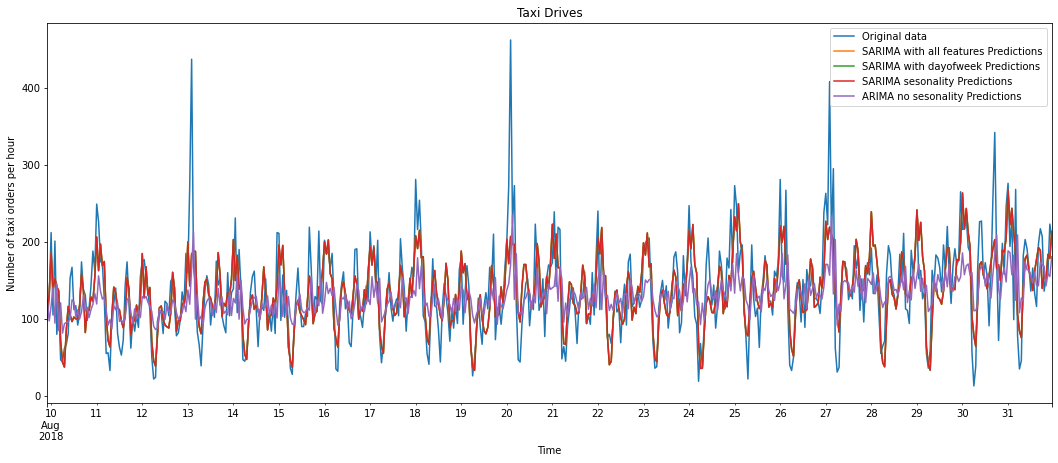

In [83]:
# Plot predictions against known values
title='Taxi Drives'
ylabel='Number of taxi orders per hour'
xlabel='Time'

plot_df = pd.DataFrame({
    'Original data' : test['num_orders'],
    'SARIMA with all features Predictions' : predictions4,
    'SARIMA with dayofweek Predictions' : predictions3,
    'SARIMA sesonality Predictions' : predictions2,
    'ARIMA no sesonality Predictions' : predictions1
}, index = test['num_orders'].index)

ax = plot_df.plot(legend=True,figsize=(18,7),title=title)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Let's zoom in to see the last 3 days for our best model SARIMA against the test target:

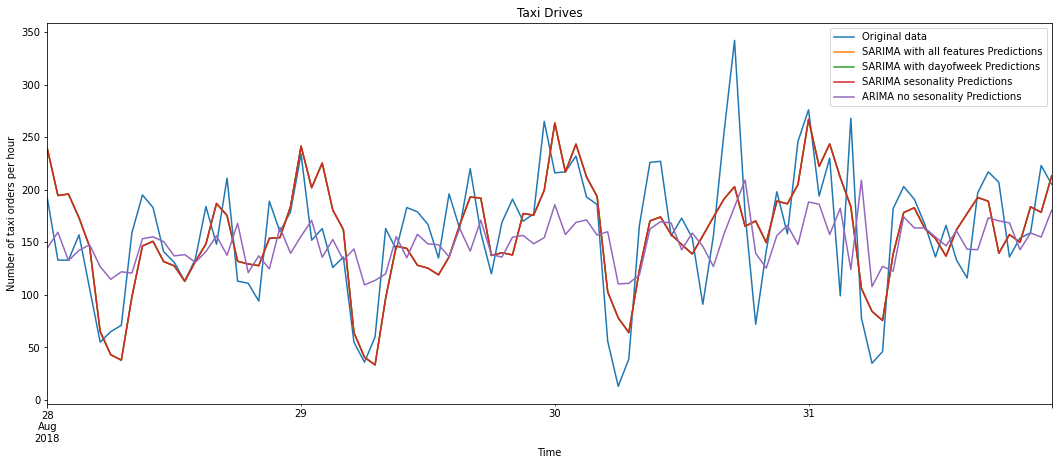

In [82]:
# Plot predictions against known values
title='Taxi Drives'
ylabel='Number of taxi orders per hour'
xlabel='Time'

plot_df = pd.DataFrame({
    'Original data' : test['num_orders'],
    'SARIMA with all features Predictions' : predictions4,
    'SARIMA with dayofweek Predictions' : predictions3,
    'SARIMA sesonality Predictions' : predictions2,
    'ARIMA no sesonality Predictions' : predictions1
}, index = test['num_orders'].index)['2018-08-28':]

ax = plot_df.plot(legend=True,figsize=(18,7),title=title)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

It seems that adding seasonality factor to the model had a great positive effect on the model's prediction ability. Adding exogenous features, though, didn't have any added value hence the models are quite similar and are combined together in the chart above.

### Sanity check

In [49]:
print('Median hourly orders:', test['num_orders'].median())
pred_median = np.ones(test['num_orders'].shape) * train['num_orders'].median()
print('RMSE:', mean_squared_error(test['num_orders'], pred_median, squared=False))

Median hourly orders: 131.0
RMSE: 86.07044065599398


We tried to predict using constant model of the median value and had RMSE of 76 on our test set. It means that all the models we used beat the baseline model.

In [50]:
pred_previous = test['num_orders'].shift(fill_value=train['num_orders'].iloc[-1]).astype('float')
print('RMSE:', mean_squared_error(test['num_orders'],pred_previous, squared=False))

RMSE: 58.35417237835067


## Bonus: Forecast The Future!!

In [51]:
from pandas.tseries.offsets import DateOffset
pred_date=[df.index[-1]+ DateOffset(hours=x)for x in range(0,446)]
features_pred=pd.DataFrame(index=pred_date[0:])

In [52]:
model = SARIMAX(df['num_orders'],order=(0,1,1),seasonal_order=(2,1,1,24),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         num_orders   No. Observations:                 4416
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 24)   Log Likelihood              -20258.368
Date:                            Wed, 02 Mar 2022   AIC                          40526.736
Time:                                    19:44:08   BIC                          40558.673
Sample:                                03-01-2018   HQIC                         40538.003
                                     - 08-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8760      0.006   -156.082      0.000      -0.887      -0.865
ar.S.L24      -0.1104      0.013     -8.193      0.000      -0.137      -0.084
ar.S.L48      -0.0068      0.014     -0.504      0.614      -0.033       0.020
ma.S.L24      -0.8940      0.008   -119.157      0.000      -0.909      -0.879
sigma2       589.3803      6.311     93.385      0.000     577.010     601.750
===================================================================================
Ljung-Box (L1) (Q):                  22.77   Jarque-Bera (JB):             12202.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.76   Skew:                             1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
start=len(df)-1
end=len(df)+2
forecast = results.predict(start=start, end=end, dynamic=False).rename('SARIMA Sesonality Future Forecast')

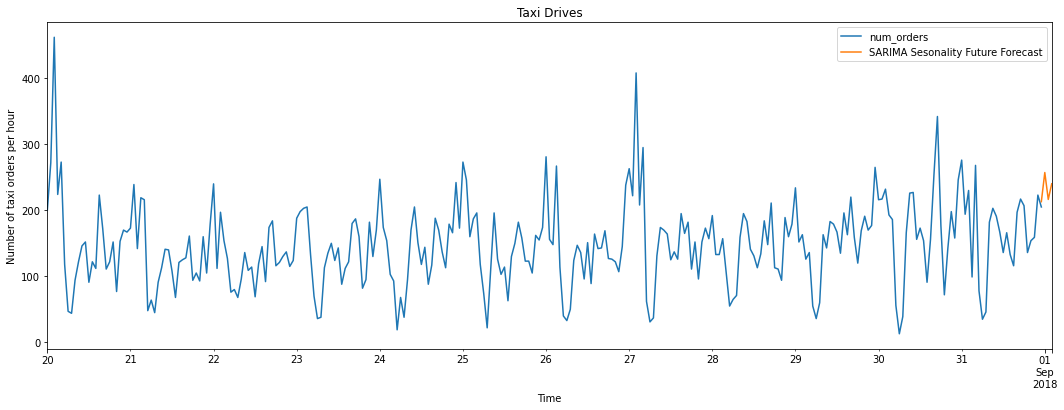

In [54]:
# Plot predictions against known values
title='Taxi Drives'
ylabel='Number of taxi orders per hour'
xlabel='Time'

ax = df['num_orders']['2018-08-20':].plot(legend=True,figsize=(18,6),title=title)
# # predictions1['2018-08-20':].plot(legend=True)
# predictions2['2018-08-20':].plot(legend=True)
# # predictions3['2018-08-20':].plot(legend=True)
# predictions4['2018-08-20':].plot(legend=True);
forecast.plot(legend=True);
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Now we fitted the chosen model SARIMA on all of the data (train and test) and predicted few hours to the unknown future. We can see the original data in blue and the forecast in orange :)

## Final Conclusion

We started with importing the data and setting the timestamp to be our index. 

Since  we need to predict the amount of taxi orders for the next hour we resampled the data by hourly frequency. 

We found an upwards trend on a daily resampling but when resampling by the hour it was hard to see a clear trend. We found out by plotting the graph that there is a daily seasonality.

We checked the data stationarity using the Dickey-Fuller test and found out it’s stationary. 
For the sake of some of the models we created new features based on the timestamp:
Year, month, day ,hour, dayofweek

We then split the data to train and test without shuffling with the test sample 12% of the initial dataset.

Then we could start building our models and evaluate them.
All models were compared to the baseline of the constant median model as a sanity test. The baseline RMSE was 76.
All models performed better than the baseline. 

First we tried the Linear Regression model that had poor results.

XGboost had much better results of 44.5. 

We wanted to improve them further by using more suited to time series models.
We tried ARIMA, SARIMA with seasonality of 24 hours (daily) and SARIMAX with different features- only day of week and all features.

From all these combinations the univariant model of SARIMA with no exogenous variables had the best outcome of RMSE= 38.9. 
Pretty good :)
